In [1]:
import qiskit
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.library import QFT
import numpy as np
from qiskit_aer import AerSimulator

In [2]:
def controlled_phase_rotation(circuit, control, target, angle):
    """Apply controlled phase rotation"""
    circuit.cp(angle, control, target)

In [18]:
def qft_adder(x_val, y_val, n_qubits):
    """
    Create a circuit that performs modular addition using QFT
    |x,y⟩ → |x,x+y mod 2^n⟩
    Args:
        n_qubits: number of qubits per register
    Returns:
        QuantumCircuit implementing the addition
    """
    if ( x_val>= 2**n_qubits):
         raise ValueError(f"The choosen value of x = {x_val}  is out of bounds!")
    if ( y_val>= 2**n_qubits):
         raise ValueError(f"The choosen value of y = {y_val}  is out of bounds!")
    # Create registers
    x = QuantumRegister(n_qubits, 'x')  # First register
    y = QuantumRegister(n_qubits, 'y')  # Second register
    cr_y = ClassicalRegister(n_qubits, 'cy')
    qc = QuantumCircuit(x, y,cr_y)
    
        # Initialize input state
    for i in range(n_qubits):
        if (x_val & (1 << i)):
            qc.x(qc.qubits[i])
        if (y_val & (1 << i)):
            qc.x(qc.qubits[n_qubits + i])
    
    # Apply QFT to the target register (y)
    qft = QFT(n_qubits, do_swaps=False)
    qc.append(qft, y[:])
    
    # Apply controlled phase rotations
    # For each qubit in x, apply controlled phase rotations to y
    for i in range(n_qubits):
        for j in range(i, n_qubits):
            theta = 2 * np.pi / (2 ** (j - i + 1))
            controlled_phase_rotation(qc, x[i], y[j], theta)
    
    # Apply inverse QFT to the target register
    iqft = QFT(n_qubits, do_swaps=False).inverse()
    qc.append(iqft, y[:])
    qc.measure(qc.qregs[1], cr_y)
    
    return qc

In [23]:
# Example usage
n_qubits = 4  # Using 3 qubits per register
x_val = 14     # First number
y_val = 5    # Second number

# Create and visualize the circuit
circuit = qft_adder(x_val, y_val, n_qubits)

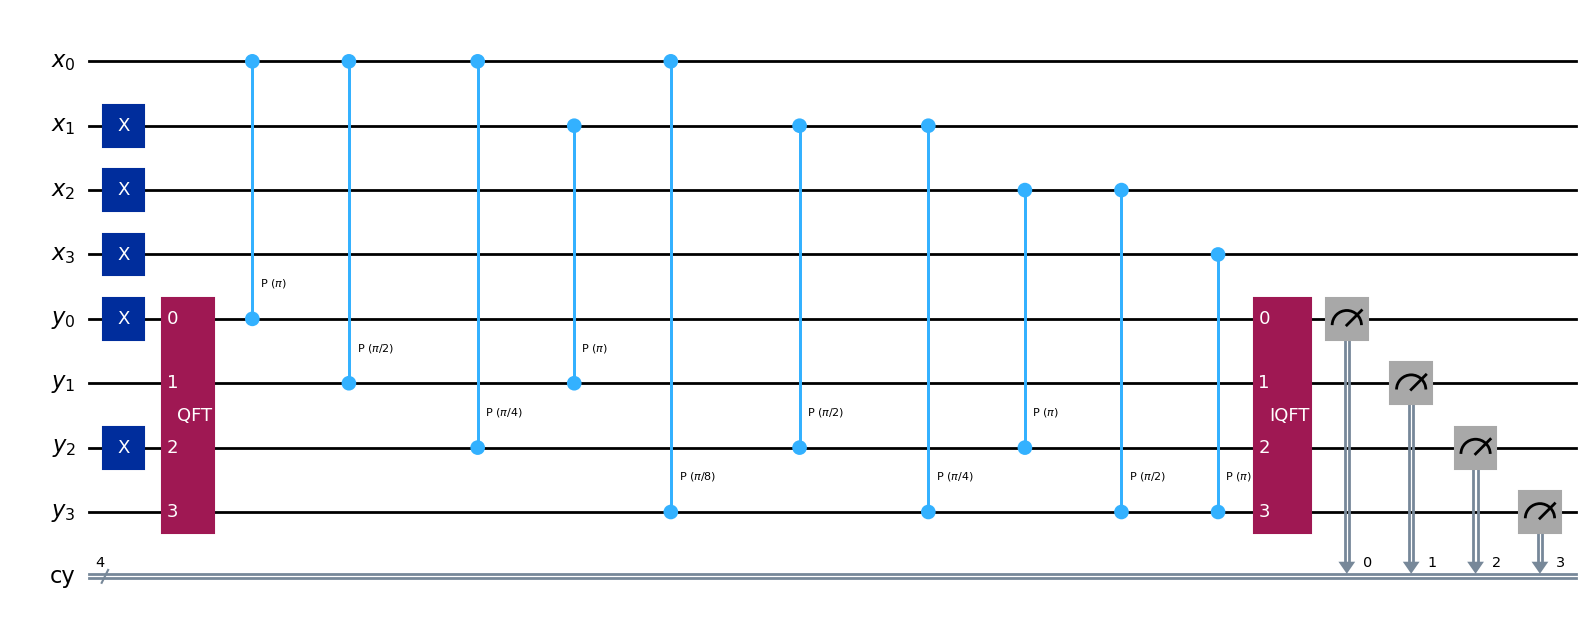

In [24]:
circuit.draw('mpl')

In [25]:
simulator = AerSimulator()
circ = qiskit.transpile(circuit, simulator)
result = simulator.run(circ,shots=100000).result()

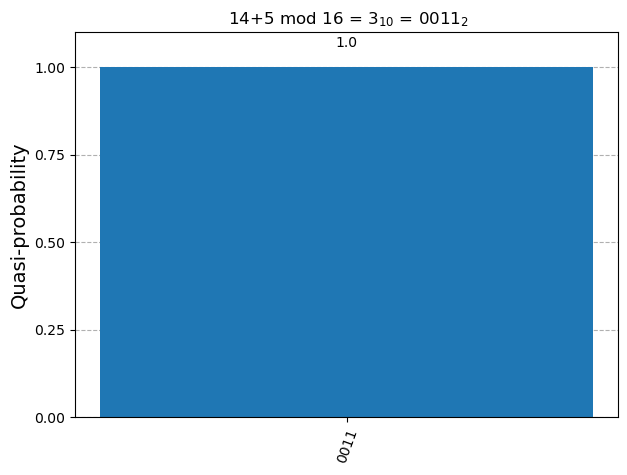

In [26]:
counts = result.get_counts(0)
qiskit.visualization.plot_distribution(counts, title=rf" {x_val}+{y_val} mod {2**n_qubits} = ${(x_val+y_val)%2**n_qubits }_{{10}}$ = ${((x_val+y_val)%2**n_qubits):0{n_qubits}b}_{{2}}$ ")

**5)**

In [27]:
def scaled_qft_adder(x_val, y_val, a,n_qubits):
    """
    Create a circuit that performs modular addition with scaling
    |x,y⟩ → |x+ay,y mod 2^n⟩
    Args:
        n_qubits: number of qubits per register
        a: scaling factor (integer)
    Returns:
        QuantumCircuit implementing the scaled addition
    """
    if ( x_val>= 2**n_qubits):
         raise ValueError(f"The choosen value of x = {x_val}  is out of bounds!")
    if ( y_val>= 2**n_qubits):
         raise ValueError(f"The choosen value of y = {y_val}  is out of bounds!")
    # Create registers
    x = QuantumRegister(n_qubits, 'x')  # First register
    y = QuantumRegister(n_qubits, 'y')  # Second register
    qc = QuantumCircuit(x, y)
    cr_x = ClassicalRegister(n_qubits, 'cx')
    qc.add_register(cr_x)
    # Initialize input state
    for i in range(n_qubits):
        if (x_val & (1 << i)):
            qc.x(qc.qubits[i])
        if (y_val & (1 << i)):
            qc.x(qc.qubits[n_qubits + i])
    # Apply QFT to the target register (x)
    qft = QFT(n_qubits, do_swaps=False)
    qc.append(qft, x[:])
        
    # Apply controlled phase rotations with scaling factor a
    for i in range(n_qubits):
        for j in range(i, n_qubits):
            theta = 2 * np.pi * a / (2 ** (j - i + 1))  # Scale the rotation by a
            controlled_phase_rotation(qc, y[i], x[j], theta)
    
    # Apply inverse QFT to the target register
    iqft = QFT(n_qubits, do_swaps=False).inverse()
    qc.append(iqft, x[:])
    qc.measure(qc.qregs[0], cr_x)
    return qc


In [37]:
n_qubits_sc = 3  # Using 3 qubits per register
x_val_sc = 0     # First number
y_val_sc = 5    # Second number
a = 6
# Create and visualize the circuit
circuit_sc = scaled_qft_adder(x_val_sc, y_val_sc,a, n_qubits_sc)

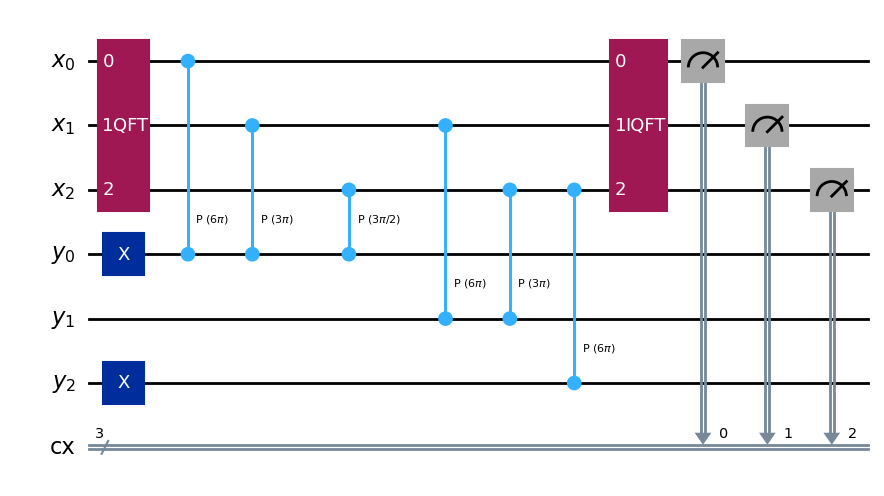

In [38]:
circuit_sc.draw('mpl')

In [39]:
circ_sc = qiskit.transpile(circuit_sc, simulator)
result_sc = simulator.run(circ_sc,shots=100000).result()

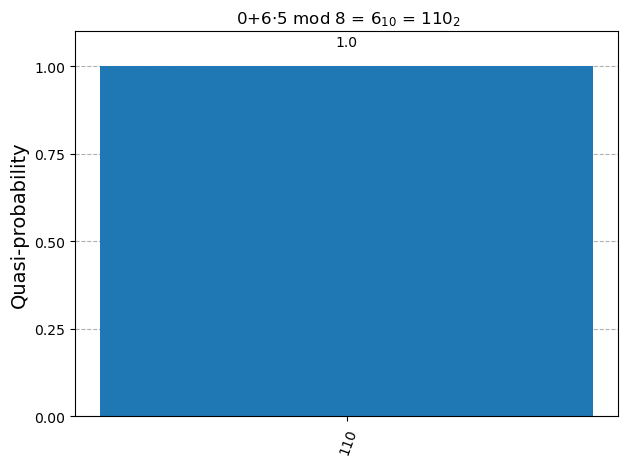

In [40]:
counts_sc = result_sc.get_counts(0)
qiskit.visualization.plot_distribution(counts_sc, title=rf" {x_val_sc}+{a}$\cdot${y_val_sc} mod {2**n_qubits_sc} = ${(x_val_sc+a*y_val_sc)%2**n_qubits_sc }_{{10}}$ = ${((x_val_sc+a*y_val_sc)%2**n_qubits_sc):0{n_qubits_sc}b}_{{2}}$ ")